In [26]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [27]:
# Estimation parameter of EKF
Q = np.diag([0.1, 0.1, np.deg2rad(1.0), 1.0])**2  # predict state covariance
R = np.diag([1.0, 1.0])**2  # Observation x,y position covariance
print("Q =", Q)
print("R =", R)

Q = [[1.0000000e-02 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e-02 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 3.0461742e-04 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00]]
R = [[1. 0.]
 [0. 1.]]


In [28]:
#  Simulation parameter
Qsim = np.diag([1.0, np.deg2rad(30.0)])**2
Rsim = np.diag([0.5, 0.5])**2
print("Qsim =", Qsim)
print("Rsim =", Rsim)

Qsim = [[1.         0.        ]
 [0.         0.27415568]]
Rsim = [[0.25 0.  ]
 [0.   0.25]]


In [29]:
DT = 0.1  # time tick [s]
SIM_TIME = 10.0  # simulation time [s]

In [30]:
def calc_input():
    v = 1.0  # [m/s]
    yawrate = 0.1  # [rad/s]
    u = np.array([[v, yawrate]]).T
    return u

In [31]:
def observation(xTrue, xd, u):

    xTrue = motion_model(xTrue, u)

    # add noise to gps x-y
    zx = xTrue[0, 0] + np.random.randn() * Rsim[0, 0]
    zy = xTrue[1, 0] + np.random.randn() * Rsim[1, 1]
    z = np.array([[zx, zy]]).T

    # add noise to input
    ud1 = u[0, 0] + np.random.randn() * Qsim[0, 0]
    ud2 = u[1, 0] + np.random.randn() * Qsim[1, 1]
    ud = np.array([[ud1, ud2]]).T

    xd = motion_model(xd, ud)

    return xTrue, z, xd, ud

In [32]:
def motion_model(x, u):

    F = np.array([[1.0, 0, 0, 0],
                  [0, 1.0, 0, 0],
                  [0, 0, 1.0, 0],
                  [0, 0, 0, 1.0]])

    B = np.array([[DT * math.cos(x[2, 0]), 0],
                  [DT * math.sin(x[2, 0]), 0],
                  [0.0, DT],
                  [DT, 0.0]])

    x = F.dot(x) + B.dot(u)

    return x

In [33]:
def observation_model(x):
    #  Observation Model
    H = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0]
    ])

    z = H.dot(x)

    return z

In [34]:
def jacobF(x, u):
    """
    Jacobian of Motion Model
    motion model
    x_{t+1} = x_t+v*dt*cos(yaw)
    y_{t+1} = y_t+v*dt*sin(yaw)
    yaw_{t+1} = yaw_t+omega*dt
    v_{t+1} = v{t}
    so
    dx/dyaw = -v*dt*sin(yaw)
    dx/dv = dt*cos(yaw)
    dy/dyaw = v*dt*cos(yaw)
    dy/dv = dt*sin(yaw)
    """
    yaw = x[2, 0]
    v = u[0, 0]
    jF = np.array([
        [1.0, 0.0, -DT * v * math.sin(yaw), DT * math.sin(yaw)],
        [0.0, 1.0, DT * v * math.cos(yaw), -DT * math.cos(yaw)],
        [0.0, 0.0, 1.0, 0.0],
        [0.0, 0.0, 0.0, 1.0]])

    return jF

In [35]:
def jacobH(x):
    # Jacobian of Observation Model
    jH = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0]
    ])

    return jH

In [36]:
def ekf_estimation(xEst, PEst, z, u):

    #  Predict
    xPred = motion_model(xEst, u)
    jF = jacobF(xPred, u)
    PPred = jF*PEst*jF.T + Q

    #  Update
    jH = jacobH(xPred)
    zPred = observation_model(xPred)
    y = z - zPred
    S = jH.dot(PPred).dot(jH.T) + R
    K = PPred.dot(jH.T).dot(np.linalg.inv(S))
    xEst = xPred + K.dot(y)
    PEst = (np.eye(len(xEst)) - K.dot(jH)).dot(PPred)

    return xEst, PEst

In [37]:
def plot_covariance_ellipse(xEst, PEst):  # pragma: no cover
    Pxy = PEst[0:2, 0:2]
    eigval, eigvec = np.linalg.eig(Pxy)

    if eigval[0] >= eigval[1]:
        bigind = 0
        smallind = 1
    else:
        bigind = 1
        smallind = 0

    t = np.arange(0, 2 * math.pi + 0.1, 0.1)
    a = math.sqrt(eigval[bigind])
    b = math.sqrt(eigval[smallind])
    x = [a * math.cos(it) for it in t]
    y = [b * math.sin(it) for it in t]
    angle = math.atan2(eigvec[bigind, 1], eigvec[bigind, 0])
    R = np.array([[math.cos(angle), math.sin(angle)],
                  [-math.sin(angle), math.cos(angle)]])
    fx = R.dot((np.array([x, y])))
    px = np.array(fx[0, :] + xEst[0, 0]).flatten()
    py = np.array(fx[1, :] + xEst[1, 0]).flatten()
    plt.plot(px, py, "--r")

In [38]:
show_animation = True

 start!!


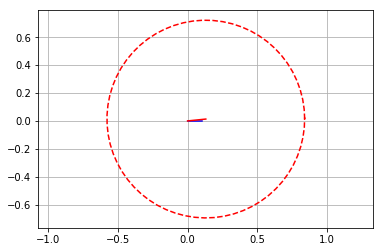

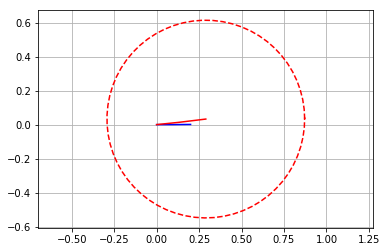

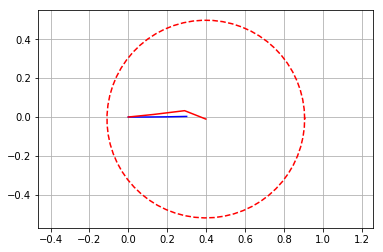

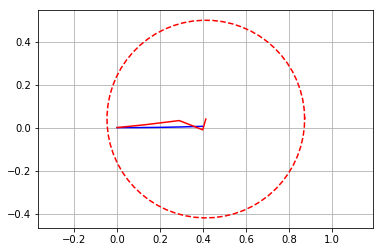

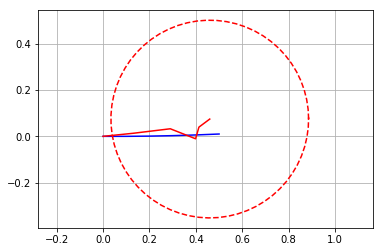

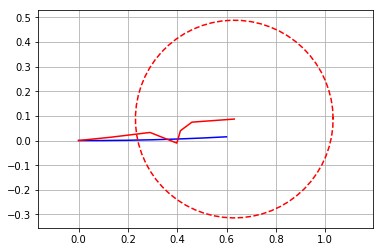

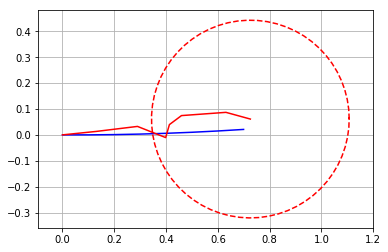

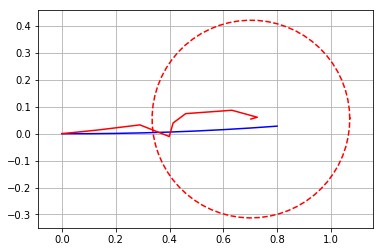

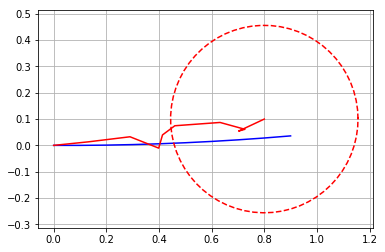

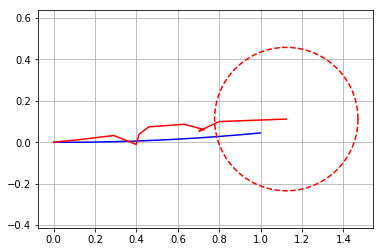

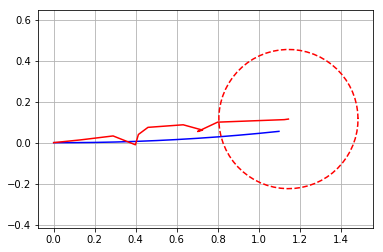

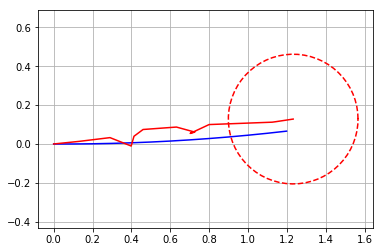

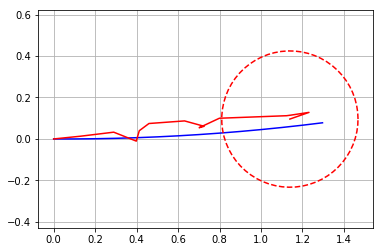

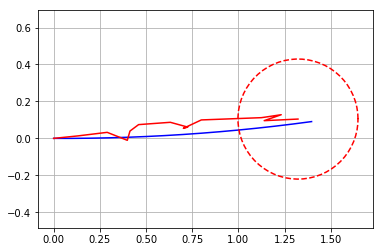

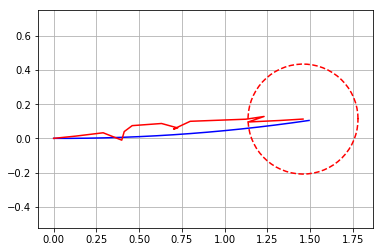

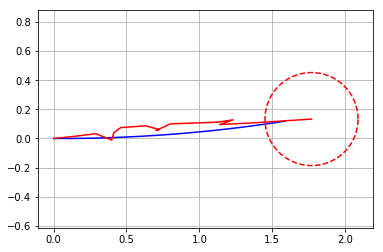

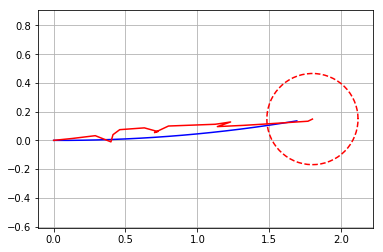

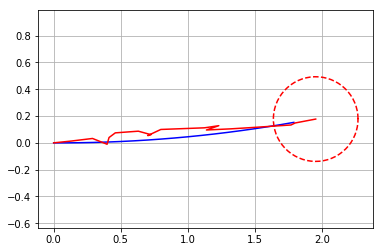

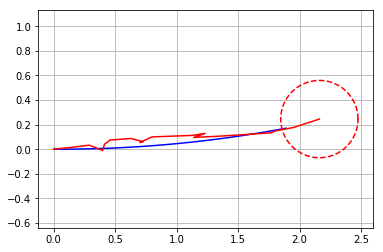

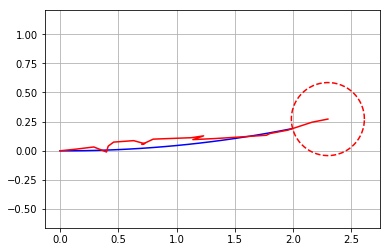

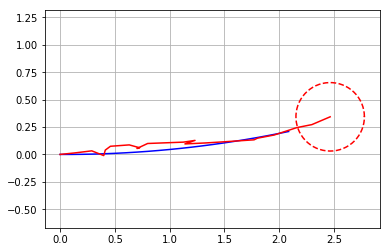

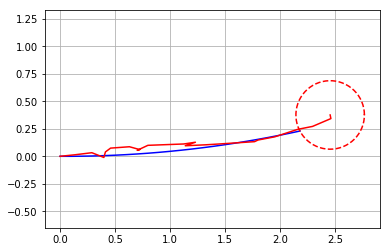

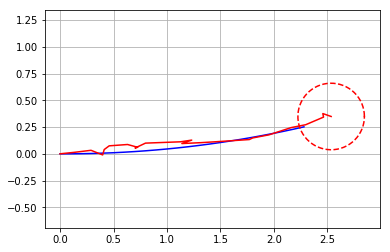

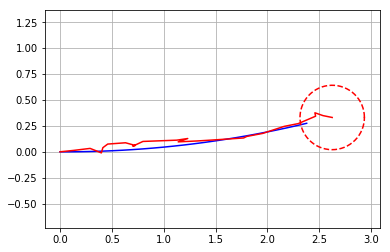

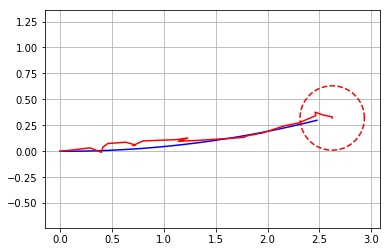

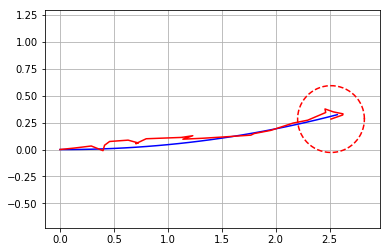

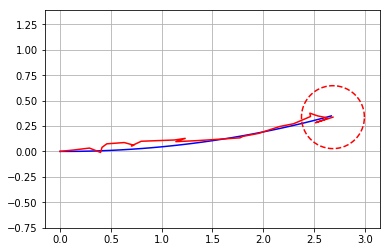

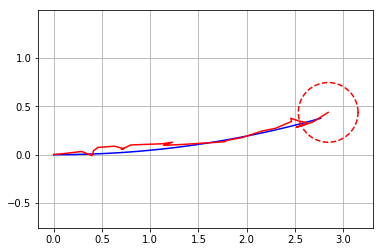

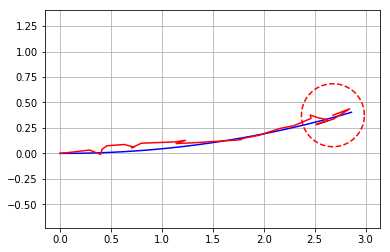

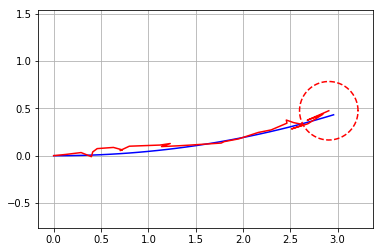

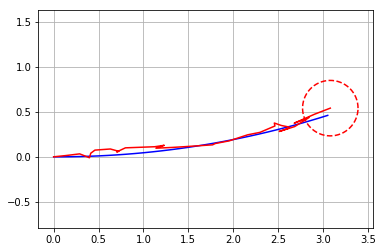

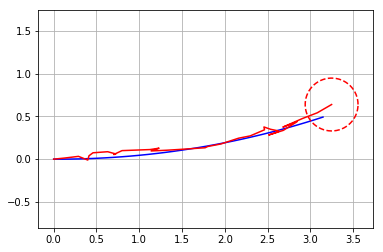

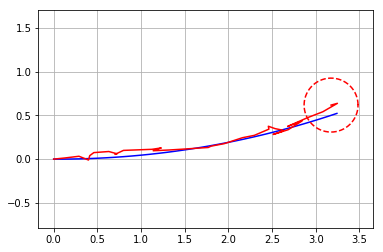

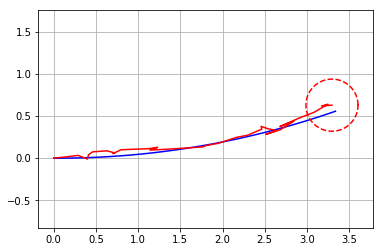

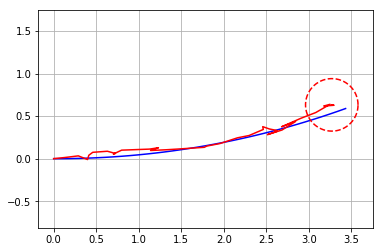

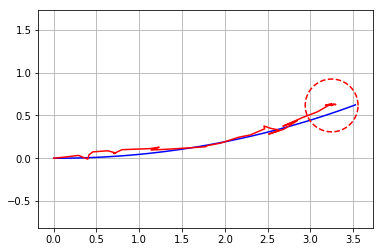

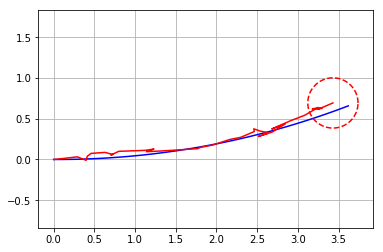

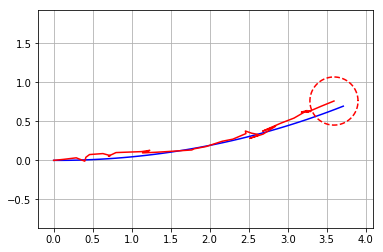

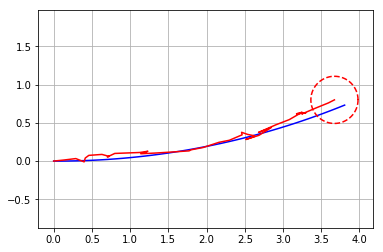

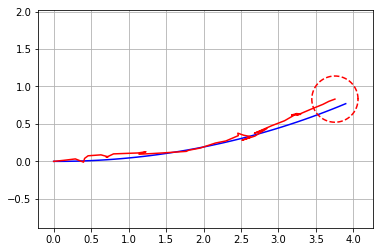

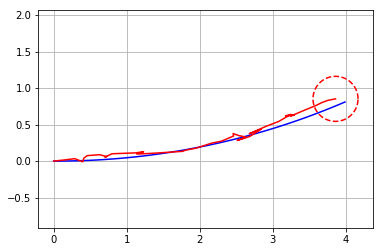

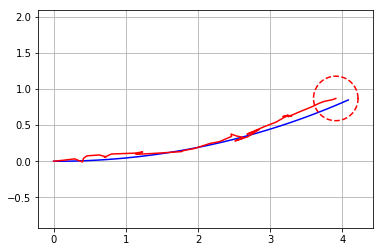

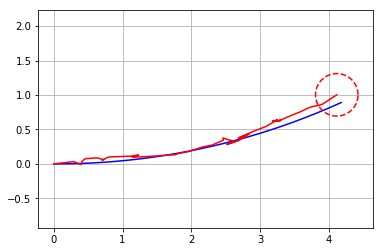

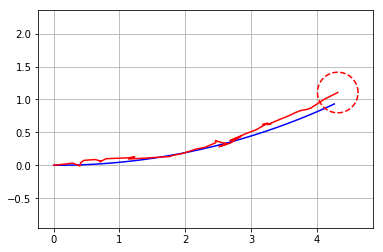

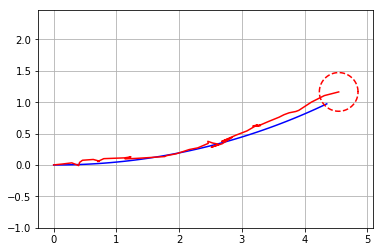

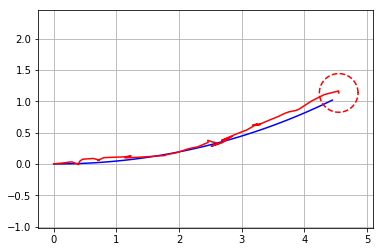

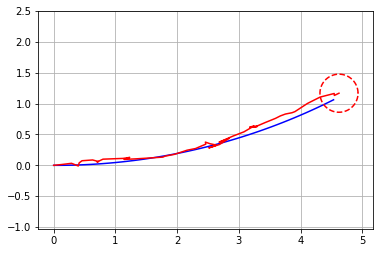

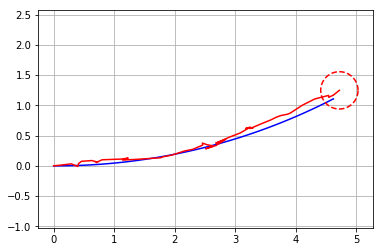

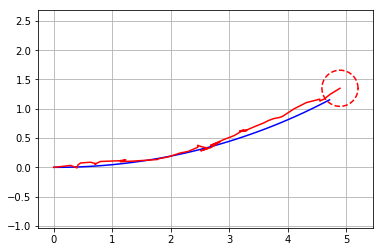

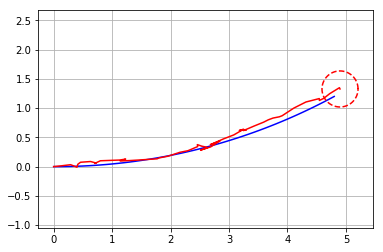

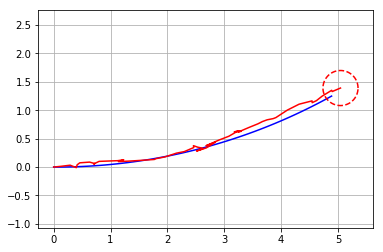

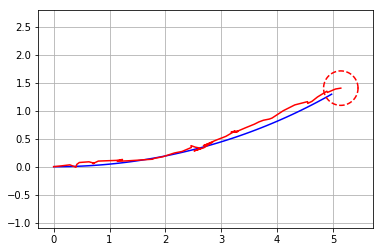

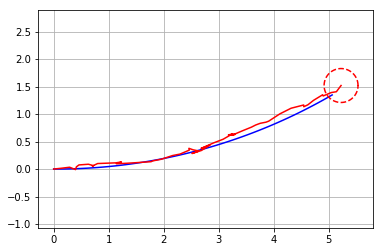

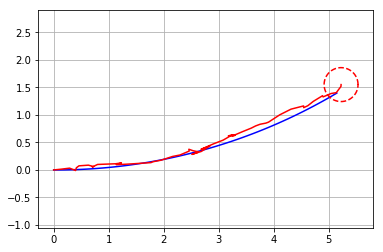

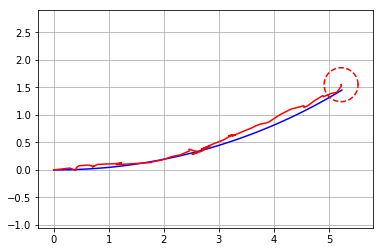

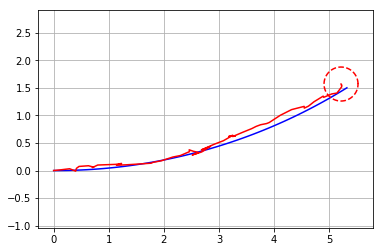

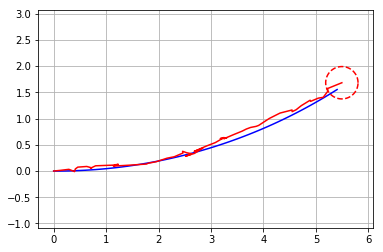

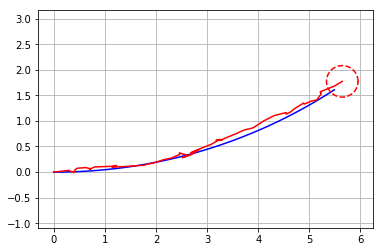

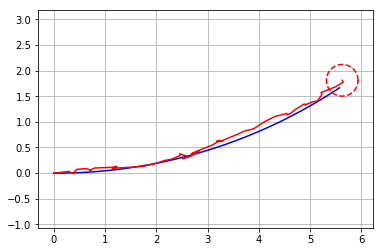

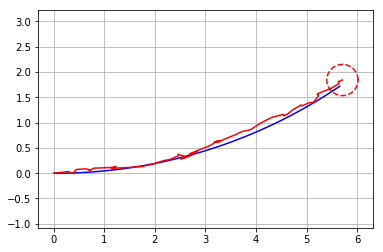

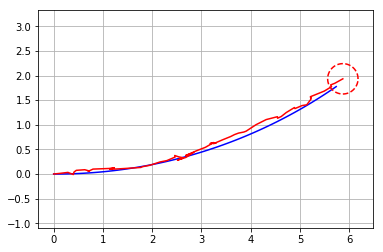

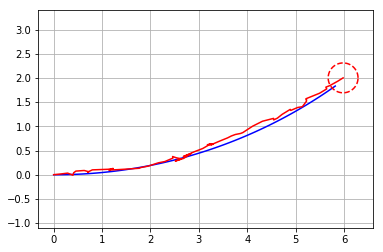

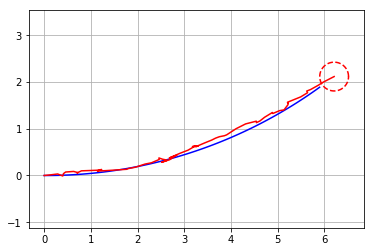

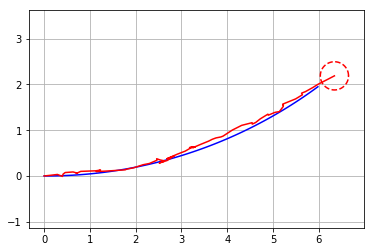

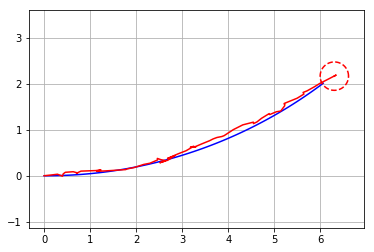

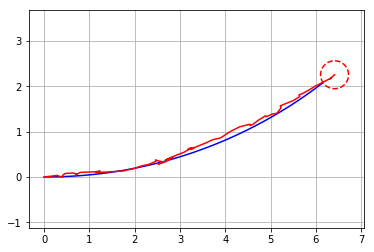

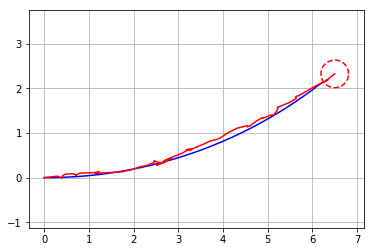

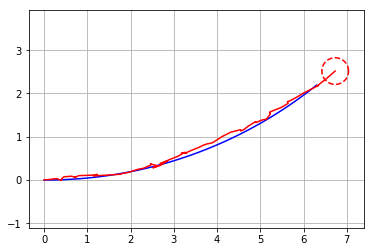

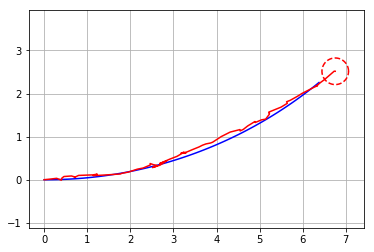

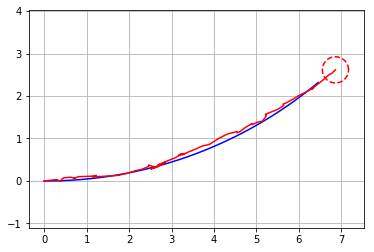

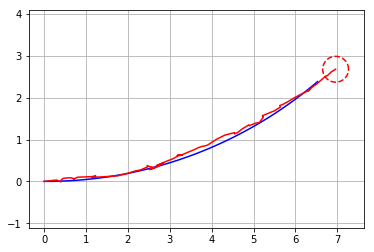

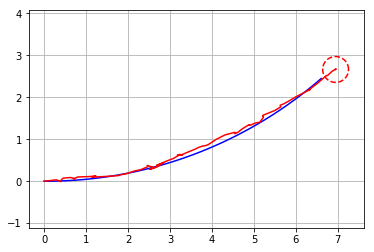

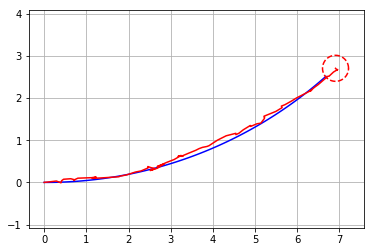

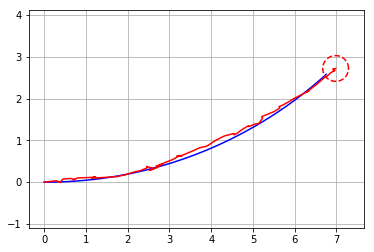

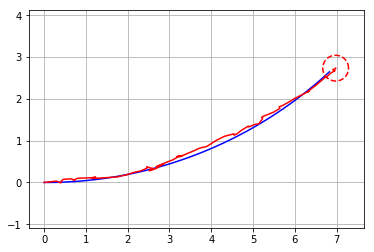

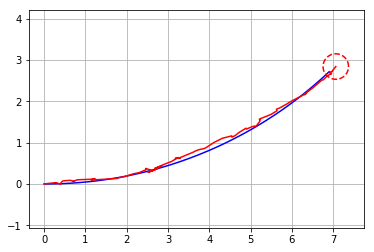

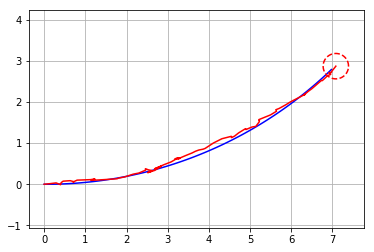

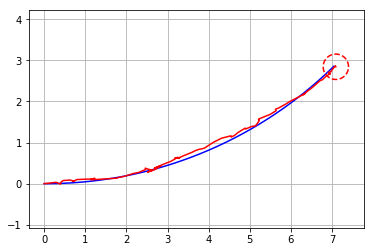

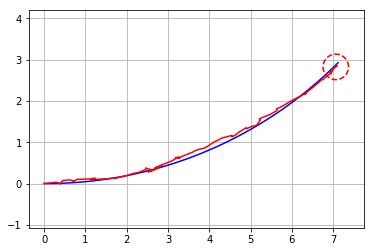

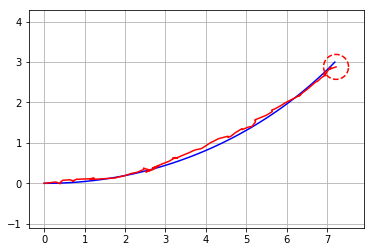

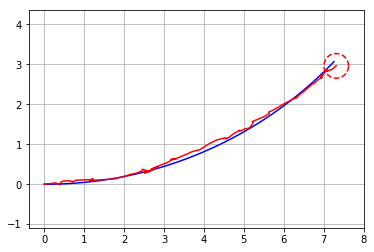

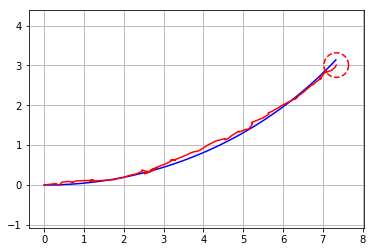

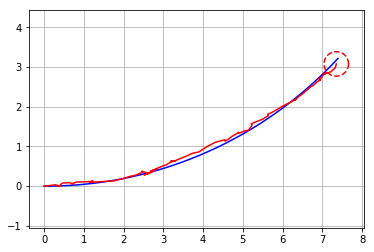

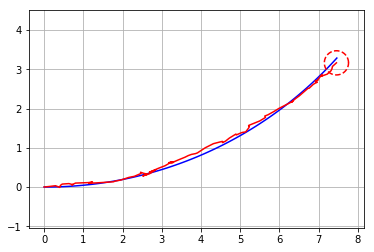

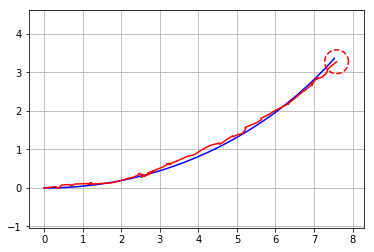

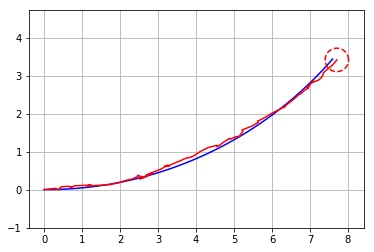

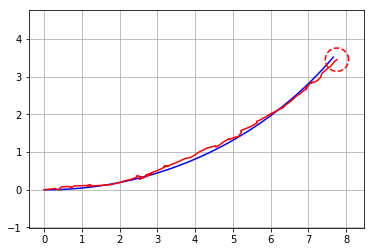

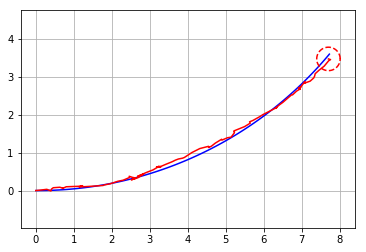

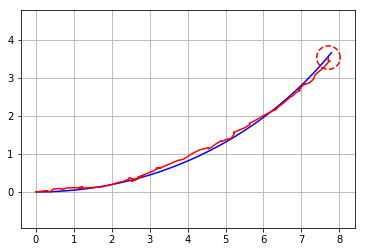

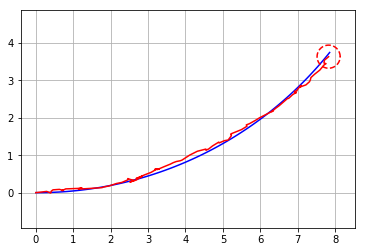

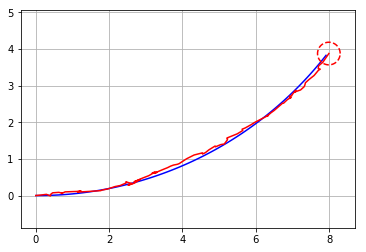

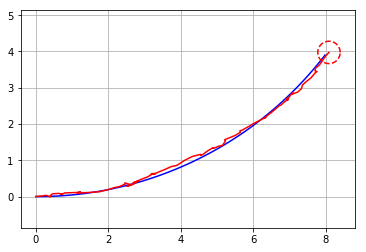

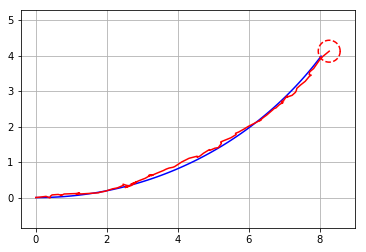

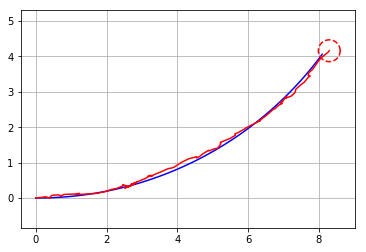

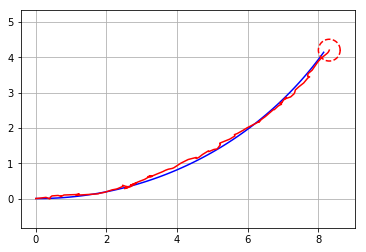

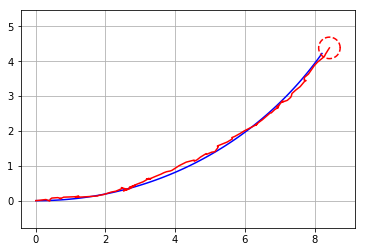

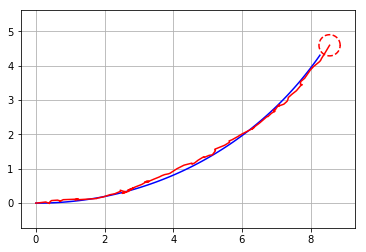

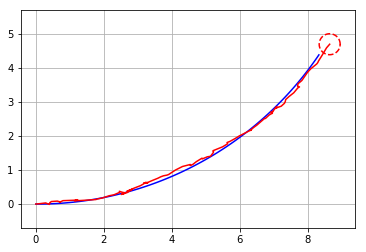

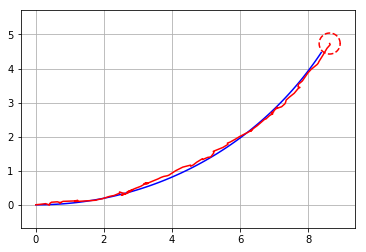

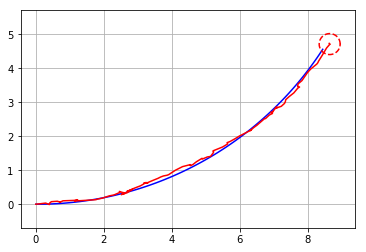

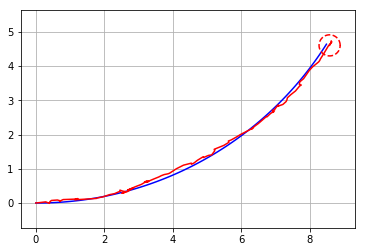

In [41]:
def main():
    print(" start!!")

    time = 0.0

    # State Vector [x y yaw v]'
    xEst = np.zeros((4, 1))
    xTrue = np.zeros((4, 1))
    PEst = np.eye(4)

    xDR = np.zeros((4, 1))  # Dead reckoning

    # history
    hxEst = xEst
    hxTrue = xTrue
    hxDR = xTrue
    hz = np.zeros((2, 1))

    while SIM_TIME >= time:
        time += DT
        u = calc_input()

        xTrue, z, xDR, ud = observation(xTrue, xDR, u)

        xEst, PEst = ekf_estimation(xEst, PEst, z, ud)

        # store data history
        hxEst = np.hstack((hxEst, xEst))
        hxDR = np.hstack((hxDR, xDR))
        hxTrue = np.hstack((hxTrue, xTrue))
        hz = np.hstack((hz, z))

        if show_animation:
            plt.cla()
            # plot the true path
            plt.plot(hxTrue[0, :].flatten(),
                     hxTrue[1, :].flatten(), "-b")
            # plot estimated path
            plt.plot(hxEst[0, :].flatten(),
                     hxEst[1, :].flatten(), "-r")
            plot_covariance_ellipse(xEst, PEst)
            plt.axis("equal")
            plt.grid(True)
            plt.pause(0.001)


if __name__ == '__main__':
    main()
